# Subtask 2 Hazard Prediction

For the second subtask I used a simple neural network with embedding, convolutional and dense layers to process and classify the text data.

In [1]:
%pip install scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install tensorflow -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install --upgrade setuptools -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install matplotlib -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import string

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import losses

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

2025-02-13 17:03:26.017811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739466206.036236   52482 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739466206.041824   52482 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 17:03:26.060449: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Preparation

Load CSV datasets

In [ ]:
labeled_train_df = pd.read_csv("incidents_train.csv").rename(columns={"Unnamed: 0": "index"})
labeled_valid_df = pd.read_csv("incidents_valid.csv").rename(columns={"Unnamed: 0": "index"})
labeled_test_df = pd.read_csv("incidents_test.csv").rename(columns={"Unnamed: 0": "index"})

We extract unique hazard categroies and we include the ones that only appear in the validation and test data in a class called "Other"

In [7]:
# Find unique categories in each dataset
train_categories = set(labeled_train_df["hazard"].unique())
valid_categories = set(labeled_valid_df["hazard"].unique())
test_categories = set(labeled_test_df["hazard"].unique())

In [8]:
# Identify extra categories in validation and test sets
extra_valid_categories = valid_categories - train_categories
extra_test_categories = test_categories - train_categories

We then create mapping dictionaries (label2id and id2label)
and apply them to the datasets<br>

In [ ]:
# Define a new category for unknown labels
OTHER_CATEGORY = "Other"

# Create label mapping for known categories (from train set)
label2id = {category: idx for idx, category in enumerate(sorted(train_categories))}
label2id[OTHER_CATEGORY] = len(label2id)  # Assign last index to "Other"
id2label = {v: k for k, v in label2id.items()}

# Number of labels
num_labels = len(label2id)

In [11]:
# Function to map labels, assigning 'Other' when necessary
def map_labels(category):
    return label2id.get(category, label2id[OTHER_CATEGORY])

# Apply label mapping
train_st1 = labeled_train_df[['text']].copy()
train_st1['label'] = labeled_train_df['hazard'].map(map_labels)

valid_st1 = labeled_valid_df[['text']].copy()
valid_st1['label'] = labeled_valid_df['hazard'].map(map_labels)

test_st1 = labeled_test_df[['text']].copy()
test_st1['label'] = labeled_test_df['hazard'].map(map_labels)

We use a custom standardization function that:
* Converts all text to lowercase.
* Replaces newlines (\n) with a space.
* Removes punctuation.

In [12]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '\n            ', ' ')
    no_punctuation = tf.strings.regex_replace(stripped_html,
                                              '[%s]' % re.escape(string.punctuation),
                                              '')
    return no_punctuation

We define a TextVectorization layer that converts raw text into integer sequences.
* max_features=20000: Uses the top 20,000 words in the dataset
* sequence_length=250: Each text sample is truncated or padded to a fixed length of 250 tokens
* The standardize function applies the custom text cleaning we defined earlier

In [13]:
max_features = 20000
sequence_length = 500

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)


2025-02-13 17:03:28.404878: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


We convert the training dataset into a TensorFlow Dataset
* train_st1["text"] contains the input text
* train_st1["label"] contains the corresponding labels

In [14]:
# Ensure tensors are explicitly set
train_st1_ds = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(train_st1["text"].values, dtype=tf.string),
    tf.convert_to_tensor(train_st1["label"].values, dtype=tf.int32)
))

# Apply mapping
text_only_train_st1_ds = train_st1_ds.map(lambda x, y: tf.cast(x, tf.string))

We define the function vectorize_text() that transforms text samples into numerical sequences using vectorize_layer.
The labels are reshaped to match expected input format.

In [15]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)  # Ensure text has shape (1,)
    label = tf.expand_dims(label, -1)  # Ensure labels have shape (1,)
    label = tf.cast(label, tf.int32)  # Convert labels to integers
    return vectorize_layer(text), label

The vectorization layer learns the vocabulary from the training data. <br>
The datasets (train_st1, valid_st1, test_st1) are mapped through vectorize_text() so that text inputs are converted to integer sequences.

In [ ]:
vectorize_layer.adapt(text_only_train_st1_ds)

train_st1 = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(train_st1["text"].values, dtype=tf.string),
    tf.convert_to_tensor(train_st1["label"].values, dtype=tf.int32)
))

valid_st1 = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(valid_st1["text"].values, dtype=tf.string),
    tf.convert_to_tensor(valid_st1["label"].values, dtype=tf.int32)
))

test_st1 = tf.data.Dataset.from_tensor_slices((
    tf.convert_to_tensor(test_st1["text"].values, dtype=tf.string),
    tf.convert_to_tensor(test_st1["label"].values, dtype=tf.int32)
))

train_ds = train_st1.map(vectorize_text)
val_ds = valid_st1.map(vectorize_text)
test_ds = test_st1.map(vectorize_text)

2025-02-13 17:03:46.974757: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


We cache the dataset to prevent redundant disk reads and then we prefetch the next batch asynchronously

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Training 

We use a neural network from Keras:
1. Input layer: Takes integer sequences of length 250.
2. Embedding layer: Converts integer tokens into dense vector representations (size 256).
3. Dropout (0.3): Prevents overfitting.
4. GlobalAveragePooling1D: Reduces the sequence into a fixed-length vector.
5. Dropout (0.3): Further regularization.
6. Dense Layer (Softmax Activation): Outputs probabilities for 129 classes.

In [ ]:
model = tf.keras.Sequential([
  layers.Input(shape=(sequence_length,)),
  layers.Embedding(max_features, 256),
  layers.Dropout(0.3),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.3),
  layers.Dense(num_labels, activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 256)       │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 129)            │        33,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,153,153 (19.66 MB)

 Trainable params: 5,153,153 (19.66 MB)

 Non-trainable params: 0 (0.00 B)

We use SparseCategoricalCrossentropy and Adam optimizer.

In [ ]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=False),  # Use CategoricalCrossentropy if labels are one-hot
              optimizer='adam',
              metrics=["accuracy"])

The training stops if the loss does not improve for 3 consecutive epochs, else the model is trained for 20 epochs.

In [21]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]
)

Epoch 1/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.2226 - loss: 3.4049 - val_accuracy: 0.3717 - val_loss: 2.6892
Epoch 2/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.3868 - loss: 2.5904 - val_accuracy: 0.4690 - val_loss: 2.2668
Epoch 3/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.4597 - loss: 2.2489 - val_accuracy: 0.5522 - val_loss: 2.0149
Epoch 4/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.5237 - loss: 1.9848 - val_accuracy: 0.5876 - val_loss: 1.8443
Epoch 5/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.5728 - loss: 1.7760 - val_accuracy: 0.6248 - val_loss: 1.7291
Epoch 6/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.6281 - loss: 1.6086 - val_accuracy: 0.6354 - val_loss: 1.6542
Epoch 7/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.6473 - loss: 1.4699 - val_accuracy: 0.6549 - val_loss: 1.5552
Epoch 8/20
5082/5082 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.6780 - loss: 1

### Evaluation

In [22]:
def history_plotter(history):
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

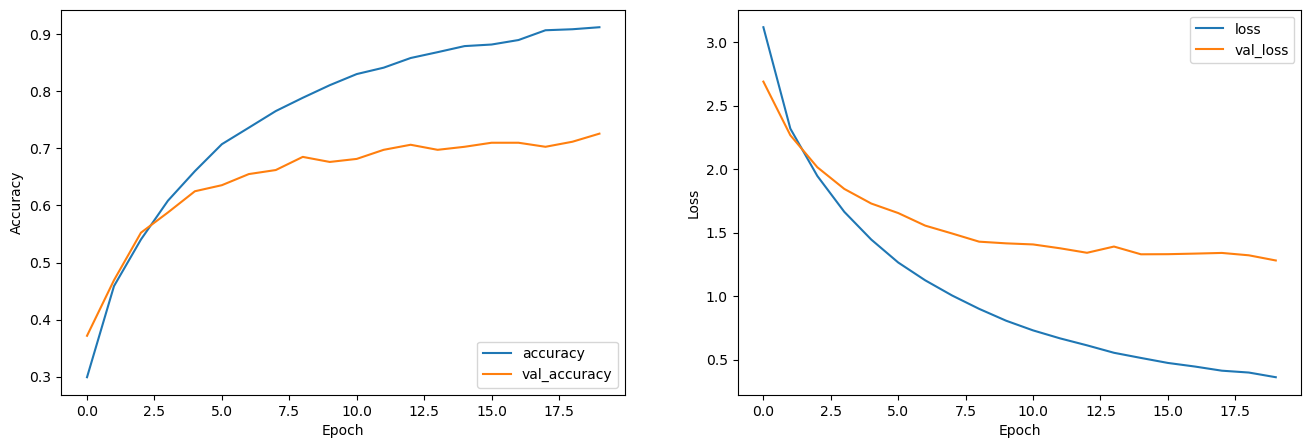

In [23]:
history_plotter(history)

In [24]:
model.evaluate(test_ds) # loss, accuracy

997/997 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.6848 - loss: 1.4536


[1.3740190267562866, 0.7191574573516846]

The model learns well the dataset initially but overfits after the 10th epoch

In order to evaluate the model on the test data we pass the predictions in a csv file that will be then be reloaded in the overview.ipynb file for the assesment

In [ ]:
predictions = model.predict(test_ds)


997/997 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step


In [ ]:
predicted_labels = tf.argmax(predictions, axis=1).numpy()

In [ ]:
true_labels = []
for _, labels in test_ds:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)

2025-02-13 17:15:42.457842: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
predicted_labels_text = [id2label[label] for label in predicted_labels]
true_labels_text = [id2label[label] for label in true_labels]

text_indices = list(range(len(predicted_labels)))

results_df = pd.DataFrame({
    'index': text_indices,
    'true_label': predicted_labels_text,
    'predicted_label': true_labels_text
})

results_df.to_csv('predictions_st2_hazard.csv', index=False)

Lastly, we compute the F1-score

In [25]:
def compute_score_1(hazards_true, hazards_pred):
  # compute f1 for hazards:
  f1_hazards = f1_score(
    hazards_true,
    hazards_pred,
    average='macro'
  )
  return f1_hazards

In [30]:
print(compute_score_1(true_labels, predicted_labels))

0.3907685380889715


The classification report highlights a significant class imbalance in the dataset. Classes with very few samples have an F1-score of 0, which lowers the macro average to __0.39__, indicating that the model struggles to classify underrepresented categories.

However, the weighted F1-score remains high at 0.72, suggesting that the model performs well on the majority classes.

In [ ]:
report = classification_report(true_labels, predicted_labels, digits=4)

print(report)

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         2
           1     0.0000    0.0000    0.0000         1
           2     0.0000    0.0000    0.0000         1
           3     0.0000    0.0000    0.0000         1
           4     0.0000    0.0000    0.0000         3
           5     0.7500    0.4615    0.5714        13
           7     0.0000    0.0000    0.0000         1
           8     1.0000    1.0000    1.0000         1
           9     1.0000    0.3333    0.5000         3
          10     0.0000    0.0000    0.0000         1
          11     0.0000    0.0000    0.0000         2
          12     0.0000    0.0000    0.0000         1
          13     0.2857    0.5000    0.3636         4
          14     0.2308    0.5000    0.3158         6
          15     1.0000    1.0000    1.0000         1
          16     0.0000    0.0000    0.0000         1
          17     0.7143    0.7317    0.7229        41
          18     0.0000    

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitali